Data Preparation and Exploration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df=pd.read_csv("/content/exchange_rate.csv")

In [ ]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [ ]:
# Check the column names in the dataset
print(df.columns)


Index(['date', 'Ex_rate'], dtype='object')


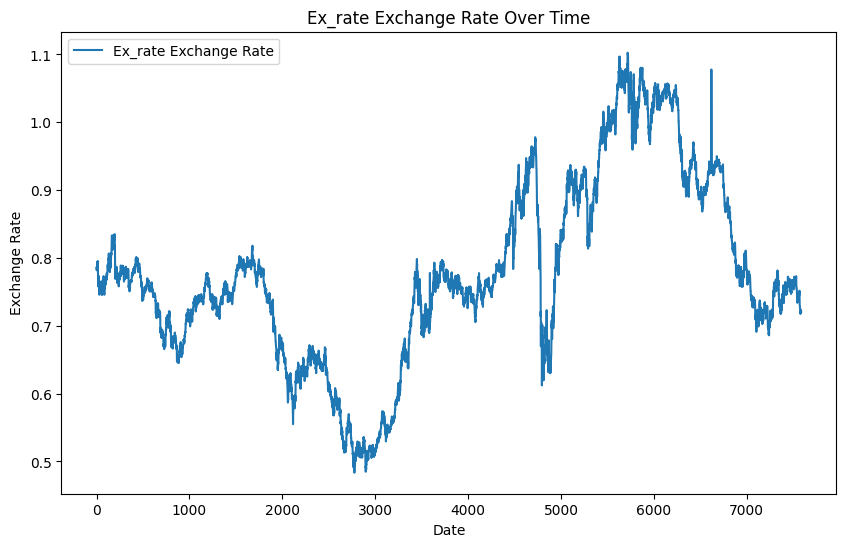

In [ ]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Ex_rate'], label='Ex_rate Exchange Rate')
plt.title('Ex_rate Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [ ]:
df.isnull().sum()

,0
date,0
Ex_rate,0


In [ ]:

# Fill missing values using forward fill or interpolation
df['Ex_rate'].fillna(method='ffill', inplace=True)

# Check for outliers (you can define outliers based on domain knowledge or statistical rules)
# Optionally remove or cap outliers

<ipython-input-49-9c4447b0f9fa>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Ex_rate'].fillna(method='ffill', inplace=True)


### Model Building - ARIMA

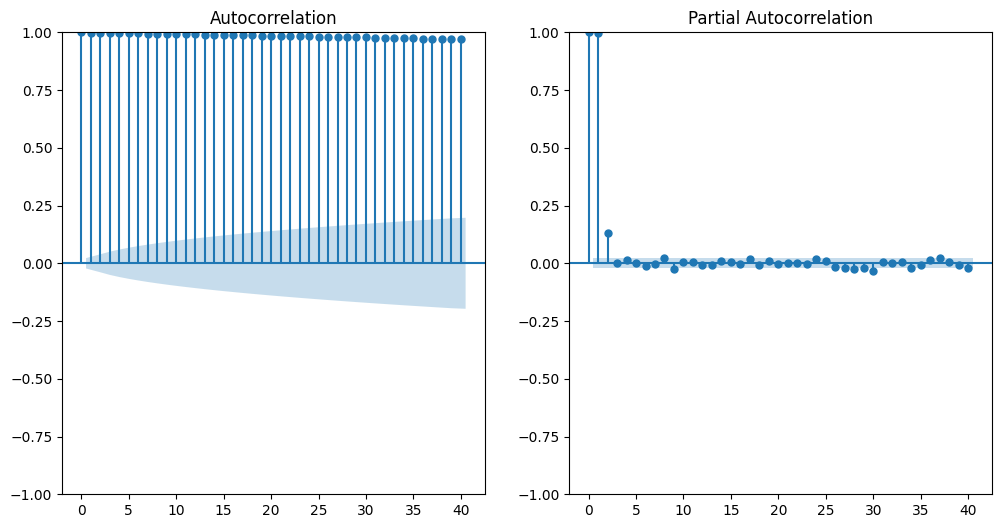

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Ex_rate'], lags=40, ax=plt.gca())
plt.subplot(122)
plot_pacf(df['Ex_rate'], lags=40, ax=plt.gca())
plt.show()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:

# Define ARIMA model (start with an initial guess for p, d, q)
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))  # Example parameters, adjust based on ACF/PACF
arima_result = model.fit()

In [ ]:
# Print model summary
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 24 Sep 2024   AIC                         -56102.322
Time:                        12:00:59   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

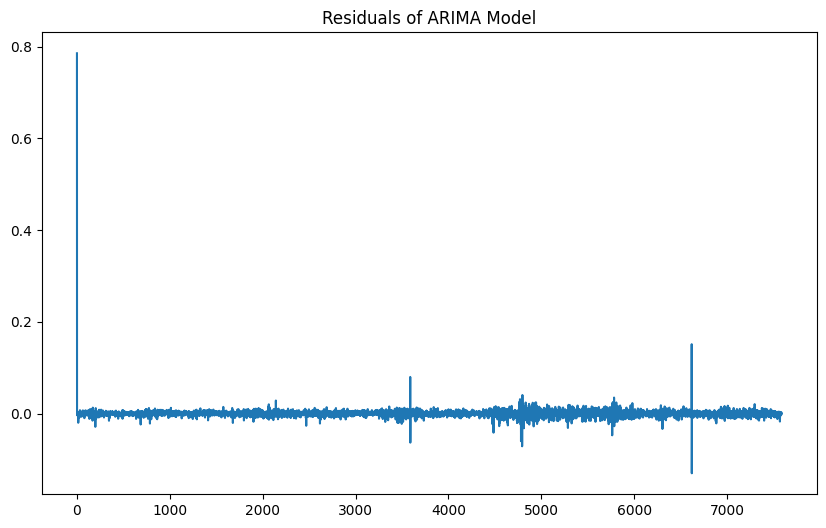

In [ ]:
# Residual diagnostics
residuals = arima_result.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()


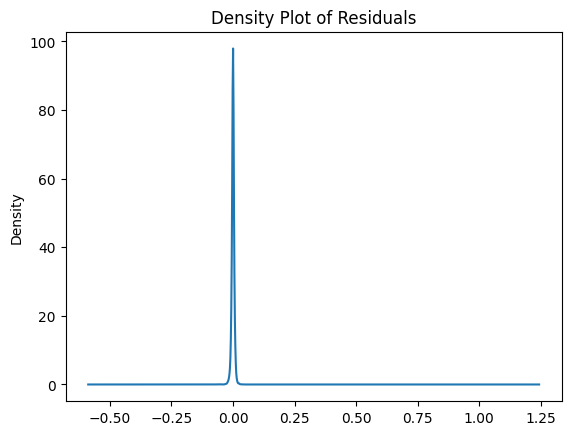

In [ ]:

# Check if the residuals are normally distributed
residuals.plot(kind='kde')
plt.title('Density Plot of Residuals')
plt.show()

In [ ]:
# Forecast future values (e.g., 30 days ahead)
forecast = arima_result.get_forecast(steps=30)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()


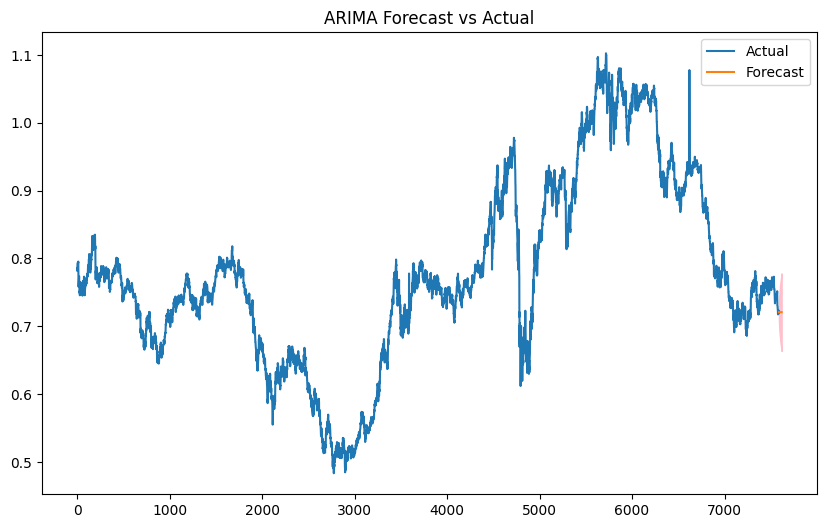

In [ ]:
# Plot forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast')
plt.fill_between(forecast_values.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

### Model Building - Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Simple model (for data with no trend or seasonality)
model_ses = ExponentialSmoothing(df['Ex_rate'], trend=None, seasonal=None)
ses_result = model_ses.fit()


In [ ]:

# Print model summary
print(ses_result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77644.981
Trend:                             None   BIC                         -77631.112
Seasonal:                          None   AICC                        -77644.975
Seasonal Periods:                  None   Date:                 Tue, 24 Sep 2024
Box-Cox:                          False   Time:                         12:04:17
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8687830                alpha                 True
initial_level              0.78514

In [ ]:
# Model fitting with optimized parameters (let the library optimize)
model_holt = ExponentialSmoothing(df['Ex_rate'], trend='add')
holt_result = model_holt.fit()

# Print model summary
print(holt_result.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Tue, 24 Sep 2024
Box-Cox:                          False   Time:                         12:04:47
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

In [ ]:
# Forecast future values
holt_forecast = holt_result.forecast(steps=30)

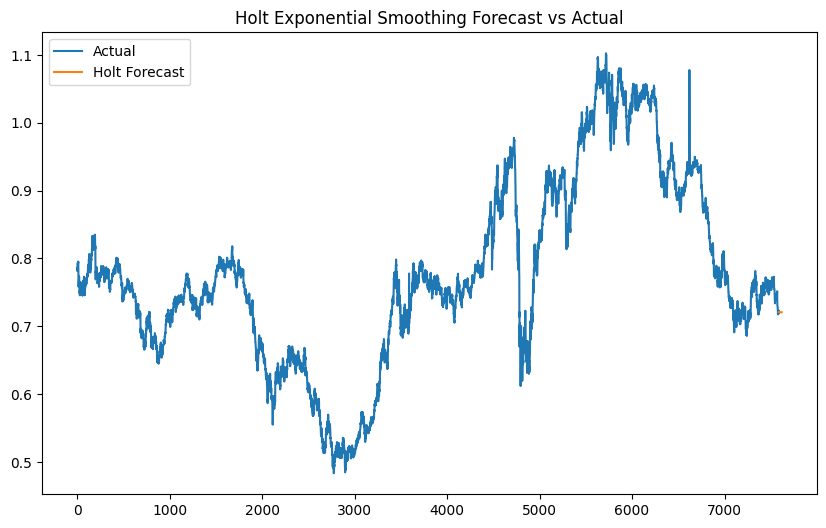

In [ ]:
# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(holt_forecast.index, holt_forecast, label='Holt Forecast')
plt.title('Holt Exponential Smoothing Forecast vs Actual')
plt.legend()
plt.show()

## Evaluation and Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
# Define function to compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Compute error metrics for ARIMA
arima_forecast_values = forecast.predicted_mean
mae_arima = mean_absolute_error(df['Ex_rate'][-30:], arima_forecast_values)
rmse_arima = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], arima_forecast_values))
mape_arima = mean_absolute_percentage_error(df['Ex_rate'][-30:], arima_forecast_values)


In [ ]:
# Compute error metrics for Exponential Smoothing
holt_forecast_values = holt_forecast
mae_holt = mean_absolute_error(df['Ex_rate'][-30:], holt_forecast_values)
rmse_holt = np.sqrt(mean_squared_error(df['Ex_rate'][-30:], holt_forecast_values))
mape_holt = mean_absolute_percentage_error(df['Ex_rate'][-30:], holt_forecast_values)


In [ ]:
print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}')
print(f'Holt - MAE: {mae_holt}, RMSE: {rmse_holt}, MAPE: {mape_holt}')

ARIMA - MAE: 0.012724006489305202, RMSE: 0.016982710912755217, MAPE: nan
Holt - MAE: 0.012755756156713368, RMSE: 0.017005229952751045, MAPE: nan
